In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import sklearn.preprocessing as pr


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#from google.colab import files 
  
  
#uploaded = files.upload()

In [ ]:
plt.style.use('bmh')
data = pd.read_csv("tweets_ready.csv")
data.shape

(11781, 15)

# Data Preprocesing

In [ ]:
# Sentiment DataSet from "Covid-19 Sentiment Analysis using SpaCy"

data.head()

,Unnamed: 0,username,created_at,verified,followers_count,date,timezone,tweet,nlikes,nreplies,nretweets,lang,sentiment,emotion,hate_speech
0,0,TeInformo24hrs,1.648233e+12,False,83739,2022-03-25 12:33:52,-600,"El presidente brasileño, Jair Bolsonaro, firmó...",0,0,0,es,NEU,others,['NEU']
1,1,TeInformo24hrs,1.648233e+12,False,83739,2022-03-25 12:23:44,-600,Nada justifica la violencia. Fomentemos valore...,0,0,0,es,NEU,others,['NEU']
2,2,TeInformo24hrs,1.648187e+12,False,83739,2022-03-24 23:46:18,-600,El presidente AMLO pide una disculpa a la gobe...,1,0,0,es,NEG,others,['NEU']
3,3,TeInformo24hrs,1.648186e+12,False,83739,2022-03-24 23:25:03,-600,Trump demanda a Hillary Clinton y al Comité Na...,1,0,0,es,NEU,others,['NEU']
4,4,TeInformo24hrs,1.648186e+12,False,83739,2022-03-24 23:23:47,-600,Video: url,1,0,0,en,NEU,others,['NEU']


In [ ]:
data['username'].nunique()

230

In [ ]:
data.columns

Index(['Unnamed: 0', 'username', 'created_at', 'verified', 'followers_count',
       'date', 'timezone', 'tweet', 'nlikes', 'nreplies', 'nretweets', 'lang',
       'sentiment', 'emotion', 'hate_speech'],
      dtype='object')



```
# This is formatted as code
```

## Preprocessing for Df1 & Df2

In [ ]:
# Getting value count for sentiment
data['sentiment'].value_counts(dropna=False)

NEU    5651
NEG    4474
POS    1656
Name: sentiment, dtype: int64

In [ ]:
# Getting value count for sentiment
data['username'].value_counts(dropna=False)

Gaby_4T            634
MaribelCruzGa13    619
DanteCo94150246    614
GStrsb             494
chenteman1969      425
                  ... 
EstebanAMX           1
ggaabboo_90210       1
CARMENSAAVEDRAS      1
Willyazul100         1
CoapaRitch           1
Name: username, Length: 230, dtype: int64

In [ ]:
len([A for A in (data['username'].value_counts() < 10) if A])

80

Text(3.8000000000000007, 0.5, 'Number of users')

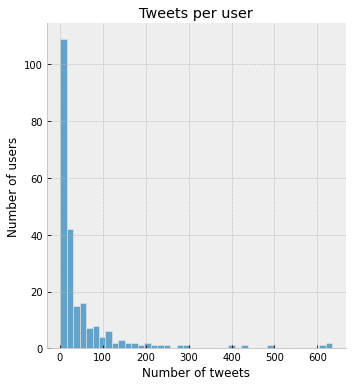

In [ ]:
ax = sns.displot(data['username'].value_counts(dropna=False).tolist())
plt.title('Tweets per user')
plt.xlabel('Number of tweets')
plt.ylabel('Number of users')
#ax.set(xticklabels=[])

In [ ]:
data['emotion'].value_counts(dropna=False)

others      7545
anger       1985
joy         1797
sadness      282
surprise      75
disgust       74
fear          23
Name: emotion, dtype: int64

Text(0, 0.5, 'Emotions')

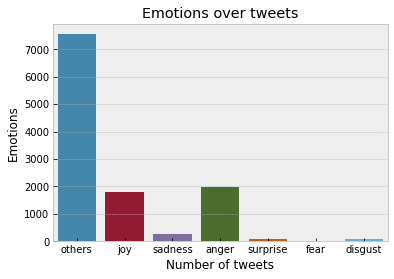

In [ ]:
ax = sns.countplot(data=data, x='emotion')
plt.title('Emotions over tweets')
plt.xlabel('Number of tweets')
plt.ylabel('Emotions')

Text(0, 0.5, 'Emotions')

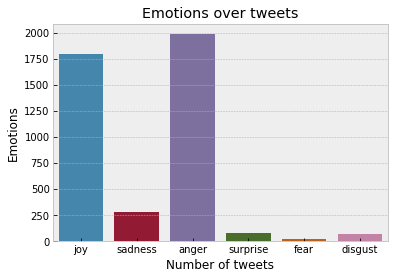

In [ ]:
ax = sns.countplot(data=data[data['emotion']!='others'], x='emotion')
plt.title('Emotions over tweets')
plt.xlabel('Number of tweets')
plt.ylabel('Emotions')

In [ ]:
data['lang'].value_counts(dropna=False)

es    11304
en      477
Name: lang, dtype: int64

In [ ]:
data['hate_speech'].value_counts(dropna=False)

['NEU']                                  11116
['hateful']                                358
['hateful', 'targeted', 'aggressive']      188
['hateful', 'aggressive']                   80
['hateful', 'targeted']                     31
['targeted']                                 8
Name: hate_speech, dtype: int64

Text(0, 0.5, 'Hate speech combinations')

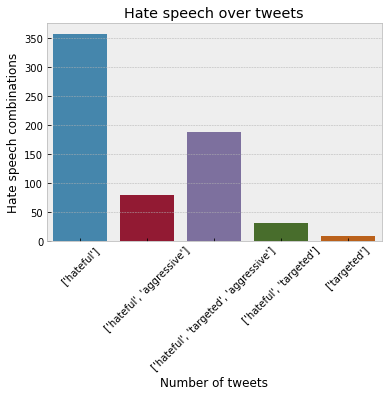

In [ ]:
ax = sns.countplot(data=data[data['hate_speech']!="['NEU']"], x='hate_speech')
plt.title('Hate speech over tweets')
plt.xlabel('Number of tweets')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel('Hate speech combinations')

In [ ]:
# Encoding setiment to {"Positive": 1, "Negative": -1, "Neutral":0}
cleanup_nums = {'sentiment': {'POS': 1, 'NEG': -1, 'NEU': 0},'lang':{'es':0, 'en':1}}
emotion_dummies = pd.get_dummies(data.emotion, prefix='Emotion')

df = data.replace(cleanup_nums)
import datetime
def parse_date(date_str, info):
  date_parsed = datetime.datetime.fromisoformat(date_str)
  if info == 'year':
    return date_parsed.year
  elif info == 'month':
    return date_parsed.month
  elif info == 'day':
    return date_parsed.day
  elif info == 'hour':
    return date_parsed.hour
  elif info == 'minute':
    return date_parsed.minute
  elif info == 'second':
    return date_parsed.second
  elif info == 'minute_day':
    return date_parsed.hour * 60 + date_parsed.minute

day_info = ['year', 'month', 'day', 'hour', 'minute', 'second', 'minute_day']
for info in day_info:
  df[info] = df['date'].map(lambda date: parse_date(date, info))

df.head()

,Unnamed: 0,username,created_at,verified,followers_count,date,timezone,tweet,nlikes,nreplies,...,sentiment,emotion,hate_speech,year,month,day,hour,minute,second,minute_day
0,0,TeInformo24hrs,1.648233e+12,False,83739,2022-03-25 12:33:52,-600,"El presidente brasileño, Jair Bolsonaro, firmó...",0,0,...,0,others,['NEU'],2022,3,25,12,33,52,753
1,1,TeInformo24hrs,1.648233e+12,False,83739,2022-03-25 12:23:44,-600,Nada justifica la violencia. Fomentemos valore...,0,0,...,0,others,['NEU'],2022,3,25,12,23,44,743
2,2,TeInformo24hrs,1.648187e+12,False,83739,2022-03-24 23:46:18,-600,El presidente AMLO pide una disculpa a la gobe...,1,0,...,-1,others,['NEU'],2022,3,24,23,46,18,1426
3,3,TeInformo24hrs,1.648186e+12,False,83739,2022-03-24 23:25:03,-600,Trump demanda a Hillary Clinton y al Comité Na...,1,0,...,0,others,['NEU'],2022,3,24,23,25,3,1405
4,4,TeInformo24hrs,1.648186e+12,False,83739,2022-03-24 23:23:47,-600,Video: url,1,0,...,0,others,['NEU'],2022,3,24,23,23,47,1403


In [ ]:
df = pd.concat([df, emotion_dummies], axis=1)


In [ ]:
df['sentiment'].value_counts(dropna=False)

 0    5651
-1    4474
 1    1656
Name: sentiment, dtype: int64

In [ ]:
df= df.drop(columns=['Unnamed: 0'])

In [ ]:
# Dropping rows with empty sentiment
df = df.dropna()


# Checking types
df.dtypes

username             object
created_at          float64
verified               bool
followers_count       int64
date                 object
timezone              int64
tweet                object
nlikes                int64
nreplies              int64
nretweets             int64
lang                  int64
sentiment             int64
emotion              object
hate_speech          object
year                  int64
month                 int64
day                   int64
hour                  int64
minute                int64
second                int64
minute_day            int64
Emotion_anger         uint8
Emotion_disgust       uint8
Emotion_fear          uint8
Emotion_joy           uint8
Emotion_others        uint8
Emotion_sadness       uint8
Emotion_surprise      uint8
dtype: object

In [ ]:
df.head()

,username,created_at,verified,followers_count,date,timezone,tweet,nlikes,nreplies,nretweets,...,minute,second,minute_day,Emotion_anger,Emotion_disgust,Emotion_fear,Emotion_joy,Emotion_others,Emotion_sadness,Emotion_surprise
0,TeInformo24hrs,1.648233e+12,False,83739,2022-03-25 12:33:52,-600,"El presidente brasileño, Jair Bolsonaro, firmó...",0,0,0,...,33,52,753,0,0,0,0,1,0,0
1,TeInformo24hrs,1.648233e+12,False,83739,2022-03-25 12:23:44,-600,Nada justifica la violencia. Fomentemos valore...,0,0,0,...,23,44,743,0,0,0,0,1,0,0
2,TeInformo24hrs,1.648187e+12,False,83739,2022-03-24 23:46:18,-600,El presidente AMLO pide una disculpa a la gobe...,1,0,0,...,46,18,1426,0,0,0,0,1,0,0
3,TeInformo24hrs,1.648186e+12,False,83739,2022-03-24 23:25:03,-600,Trump demanda a Hillary Clinton y al Comité Na...,1,0,0,...,25,3,1405,0,0,0,0,1,0,0
4,TeInformo24hrs,1.648186e+12,False,83739,2022-03-24 23:23:47,-600,Video: url,1,0,0,...,23,47,1403,0,0,0,0,1,0,0


In [ ]:
df.describe()

,created_at,followers_count,timezone,nlikes,nreplies,nretweets,lang,sentiment,year,month,...,minute,second,minute_day,Emotion_anger,Emotion_disgust,Emotion_fear,Emotion_joy,Emotion_others,Emotion_sadness,Emotion_surprise
count,1.178100e+04,11781.000000,11781.0,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.0,11781.0,...,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000
mean,1.647770e+12,4080.901367,-600.0,12.723793,0.872507,3.346320,0.040489,-0.239199,2022.0,3.0,...,29.431882,28.992700,854.489177,0.168492,0.006281,0.001952,0.152534,0.640438,0.023937,0.006366
std,3.458412e+08,8501.375399,0.0,304.441226,14.138811,80.385259,0.197111,0.680553,0.0,0.0,...,17.615032,17.577622,350.963383,0.374318,0.079009,0.044144,0.359553,0.479892,0.152859,0.079537
min,1.646464e+12,401.000000,-600.0,0.000000,0.000000,0.000000,0.000000,-1.000000,2022.0,3.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.647571e+12,594.000000,-600.0,0.000000,0.000000,0.000000,0.000000,-1.000000,2022.0,3.0,...,14.000000,14.000000,612.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.647834e+12,1371.000000,-600.0,1.000000,0.000000,0.000000,0.000000,0.000000,2022.0,3.0,...,30.000000,29.000000,857.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.648050e+12,4605.000000,-600.0,2.000000,1.000000,0.000000,0.000000,0.000000,2022.0,3.0,...,45.000000,44.000000,1146.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.648237e+12,83739.000000,-600.0,24257.000000,1027.000000,5991.000000,1.000000,1.000000,2022.0,3.0,...,59.000000,59.000000,1439.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Exploratory Data Analysis

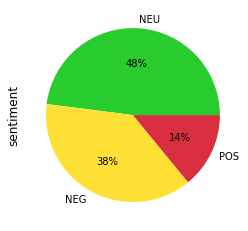

In [ ]:
# Mapping back to descriptive sentiment for better interpretation
data['sentiment'] = data['sentiment']

# Plotting Sentiment proportions
data.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["#28cc2d", "#ffe135", "#d82e3f"])


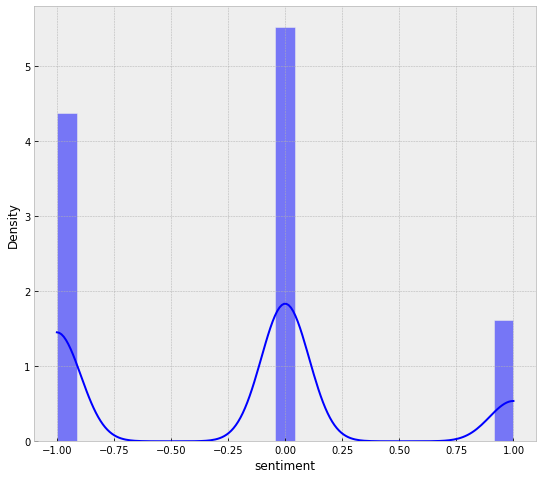

In [ ]:
x =(df['sentiment'])    
plt.figure(figsize=(9, 8))

ax = sns.histplot(x, kde= True, stat='density', label='samples')

In [ ]:
df['sentiment'].value_counts(dropna=False)

 0    5651
-1    4474
 1    1656
Name: sentiment, dtype: int64

In [ ]:
list(set(df.dtypes.tolist()))
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,created_at,followers_count,timezone,nlikes,nreplies,nretweets,lang,sentiment,year,month,day,hour,minute,second,minute_day
0,1.648233e+12,83739,-600,0,0,0,0,0,2022,3,25,12,33,52,753
1,1.648233e+12,83739,-600,0,0,0,0,0,2022,3,25,12,23,44,743
2,1.648187e+12,83739,-600,1,0,0,0,-1,2022,3,24,23,46,18,1426
3,1.648186e+12,83739,-600,1,0,0,0,0,2022,3,24,23,25,3,1405
4,1.648186e+12,83739,-600,1,0,0,1,0,2022,3,24,23,23,47,1403


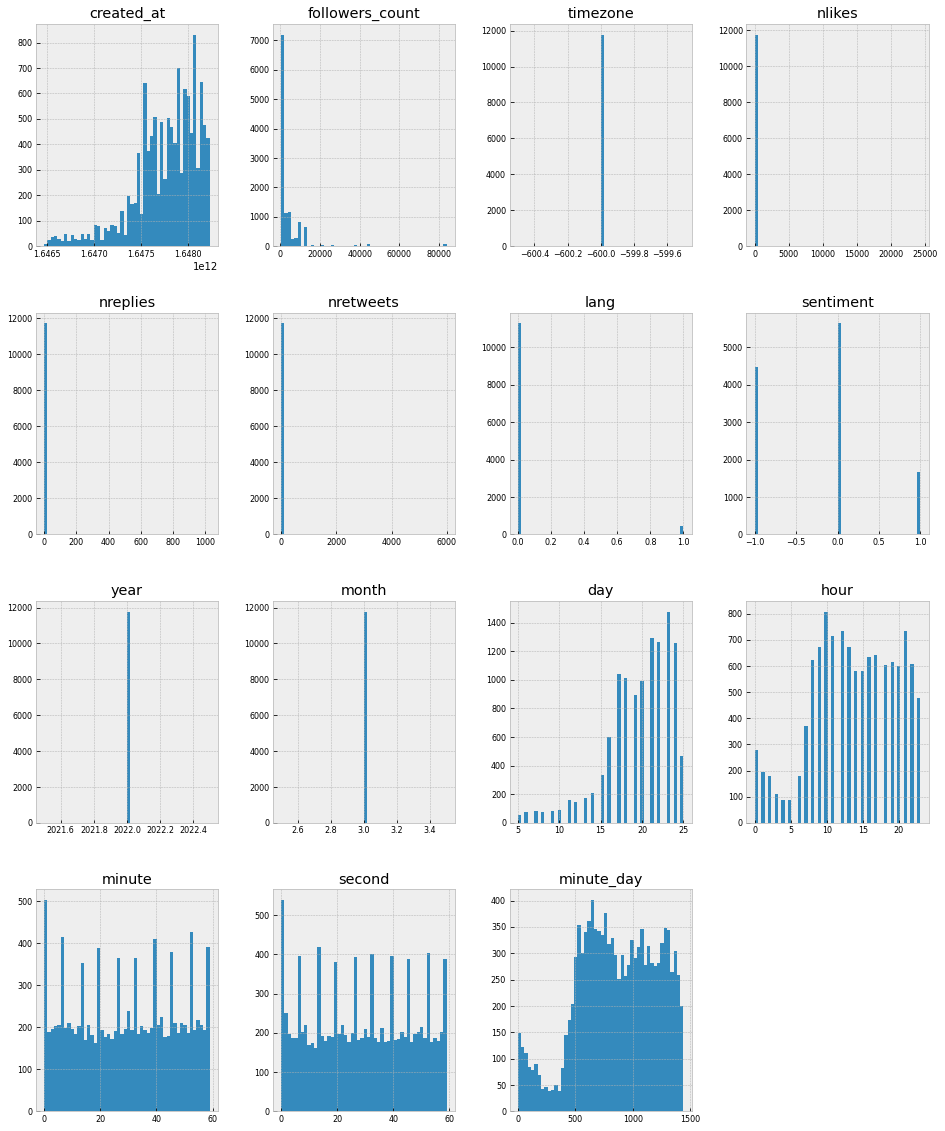

In [ ]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # 
plt.savefig ('dist_all.svg')

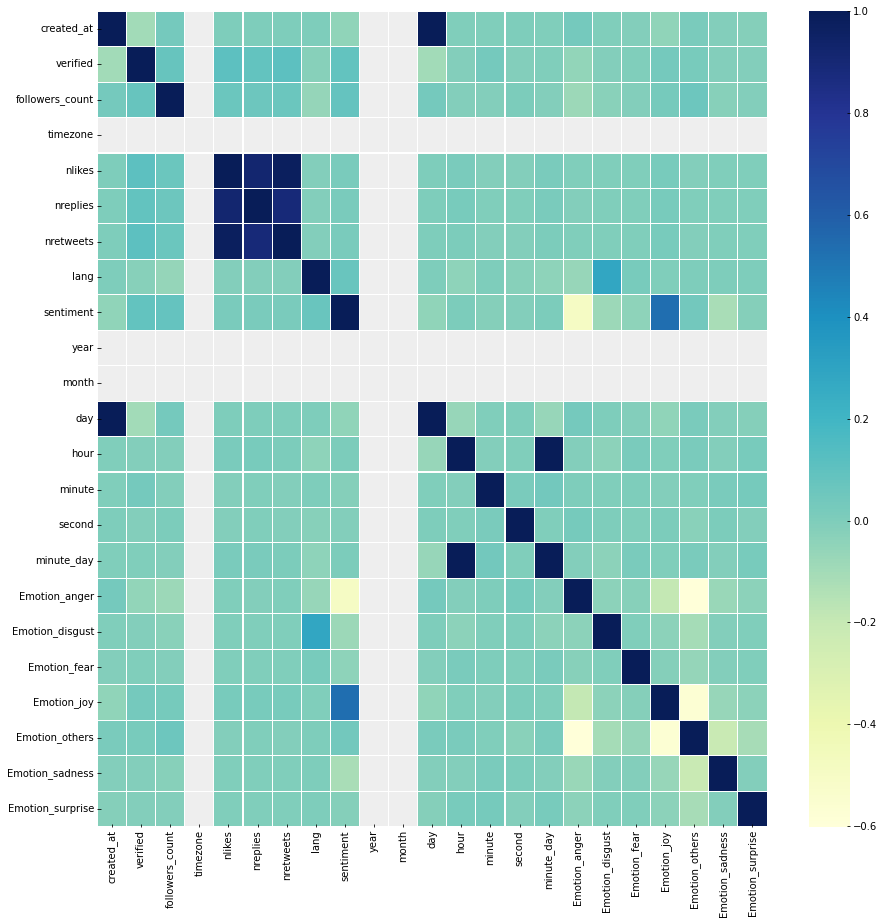

In [ ]:
corrmat = df.corr()

f, ax = plt.subplots(figsize =(15, 15))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [ ]:
list(set(df.dtypes.tolist()))
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,created_at,followers_count,timezone,nlikes,nreplies,nretweets,lang,sentiment,year,month,day,hour,minute,second,minute_day
0,1.648233e+12,83739,-600,0,0,0,0,0,2022,3,25,12,33,52,753
1,1.648233e+12,83739,-600,0,0,0,0,0,2022,3,25,12,23,44,743
2,1.648187e+12,83739,-600,1,0,0,0,-1,2022,3,24,23,46,18,1426
3,1.648186e+12,83739,-600,1,0,0,0,0,2022,3,24,23,25,3,1405
4,1.648186e+12,83739,-600,1,0,0,1,0,2022,3,24,23,23,47,1403


In [ ]:
#individual_features_df = []
#for i in range(0, len(df_num.columns) - 1): # -1 because the last column is SalePrice
#    tmpDf = df_num[[df_num.columns[i], 'SalePrice']]
#    tmpDf = tmpDf[tmpDf[df_num.columns[i]] != 0]
#    individual_features_df.append(tmpDf)

#all_correlations = {feature.columns[0]: feature.corr()['SalePrice'][0] for feature in individual_features_df}
#all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
#for (key, value) in all_correlations:
#    print("{:>15}: {:>15}".format(key, value))

In [ ]:
df_num_corr = df_num.corr()['nlikes'][1:10]
golden_features_list = df_num_corr[abs(df_num_corr) > .5].sort_values(ascending=False)
print("There is {} strongly correlated values:\n{}".format(len(golden_features_list), golden_features_list))

There is 3 strongly correlated values:
nlikes       1.000000
nretweets    0.980260
nreplies     0.924746
Name: nlikes, dtype: float64


In [ ]:
df_num_corr = df_num.corr()['followers_count'][1:10]
golden_features_list = df_num_corr[abs(df_num_corr) > .001].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

There is 6 strongly correlated values with SalePrice:
followers_count    1.000000
sentiment          0.084026
nretweets          0.067407
nlikes             0.063549
nreplies           0.056396
lang              -0.060946
Name: followers_count, dtype: float64


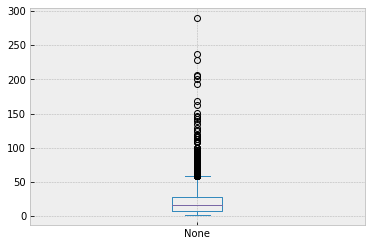

In [ ]:
# Plotting Tweet Lenghts

# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['tweet']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

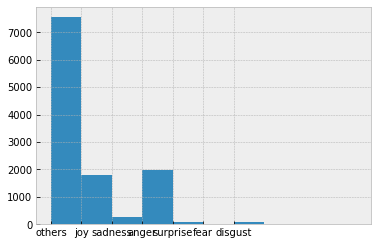

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = df['emotion']
ax.hist(x, np.arange(0, 11))
plt.show()

In [ ]:
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df['weekday'] = df['day'].map(lambda w: week[w%7])
group_size = 3
df['group_hours'] = df['hour'].map(lambda w: w//group_size)

In [ ]:
df['weekday']

0          Friday
1          Friday
2        Thursday
3        Thursday
4        Thursday
           ...   
11776      Monday
11777      Monday
11778      Monday
11779      Monday
11780      Monday
Name: weekday, Length: 11781, dtype: object

Text(0, 0.5, 'Weekdays')

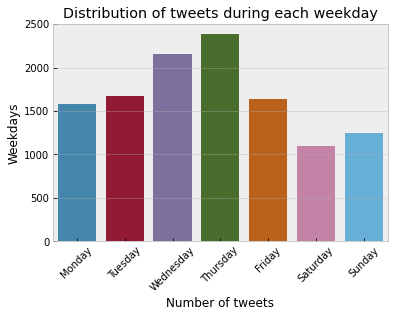

In [ ]:
sns.countplot(data=df, x='weekday', order=week)
plt.title('Distribution of tweets during each weekday')
plt.xlabel('Number of tweets')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel('Weekdays')


Text(0.5, 0, 'Hours per day')

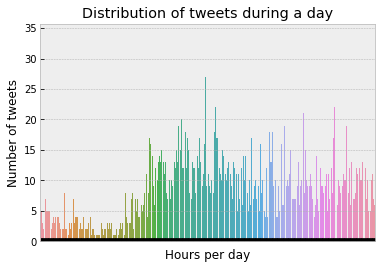

In [ ]:
ax = sns.countplot(data=df, x='minute_day')
plt.title('Distribution of tweets during a day')
plt.ylabel('Number of tweets')
ax.set(xticklabels=[])
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel('Hours per day')

In [ ]:
df.columns

Index(['username', 'created_at', 'verified', 'followers_count', 'date',
       'timezone', 'tweet', 'nlikes', 'nreplies', 'nretweets', 'lang',
       'sentiment', 'emotion', 'hate_speech', 'year', 'month', 'day', 'hour',
       'minute', 'second', 'minute_day', 'Emotion_anger', 'Emotion_disgust',
       'Emotion_fear', 'Emotion_joy', 'Emotion_others', 'Emotion_sadness',
       'Emotion_surprise', 'weekday', 'group_hours'],
      dtype='object')

In [ ]:
df['emotion'].unique()

array(['others', 'joy', 'sadness', 'anger', 'surprise', 'fear', 'disgust'],
      dtype=object)

In [ ]:
users = df['username'].unique()

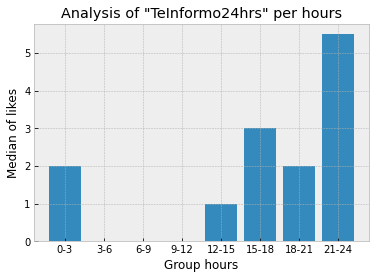

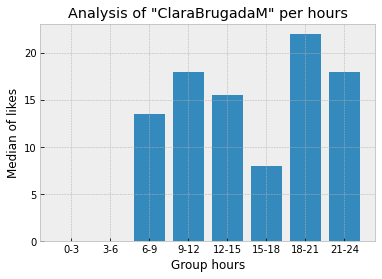

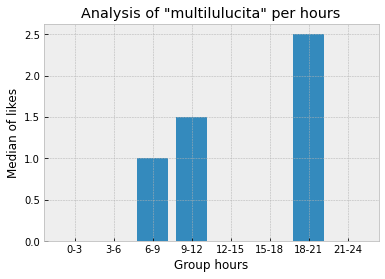

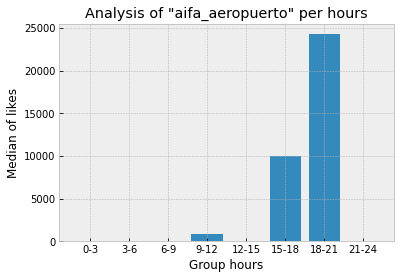

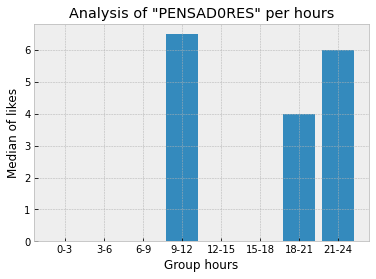

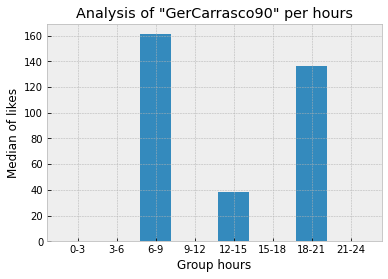

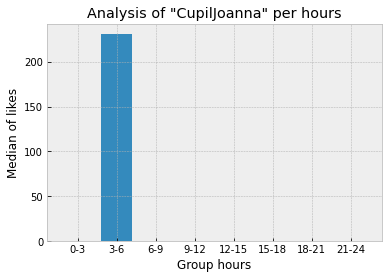

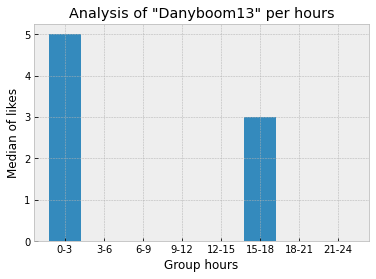

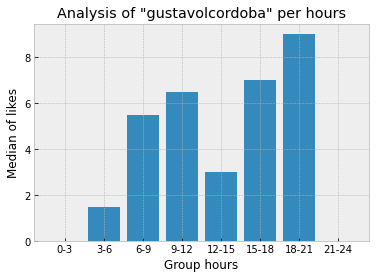

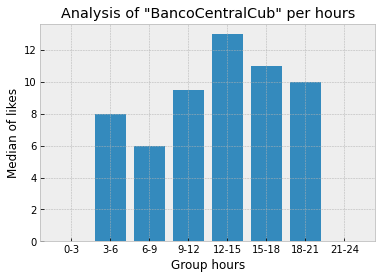

In [ ]:
for user in users[:10]:
  df_user = df[df['username'] == user]# and df['emotion'] == 'surprise']
  #df_user = df_user[df_user['emotion'] == 'surprise']
  #if len(df_user) < 20:
  #  continue

  group_hours = range(24//group_size)
  prev = 0
  group_names = []
  for group in group_hours:
    group_names.append(f'{prev}-{(group+1)*group_size}')
    prev = (group+1)*group_size

  nlikes_dist = df_user.groupby('group_hours')['nlikes'].median()
  nlikes_group = []
  for group in group_hours:
    if group in nlikes_dist:
      nlikes_group.append(nlikes_dist[group])
    else:
      nlikes_group.append(0)
  df_group = pd.DataFrame({"nlikes":nlikes_group}, index = group_hours)
  plt.bar(group_names, nlikes_group)
  plt.title(f'Analysis of "{user}" per hours')
  plt.ylabel('Median of likes')
  plt.xlabel('Group hours')
  plt.show()

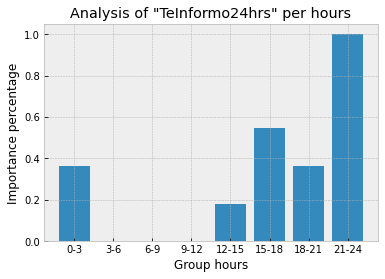

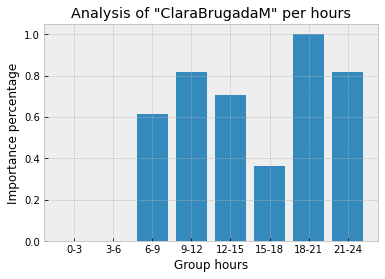

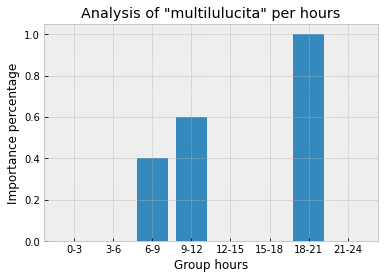

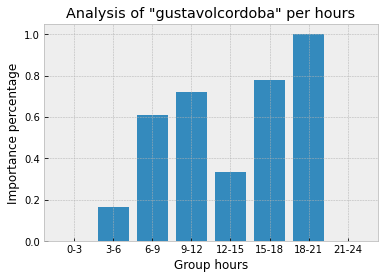

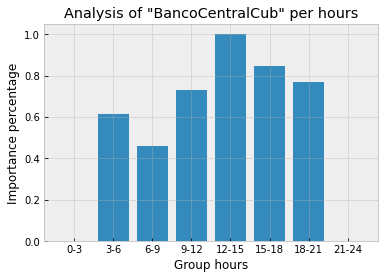

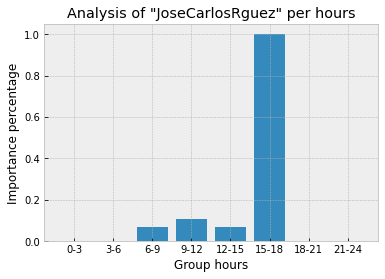

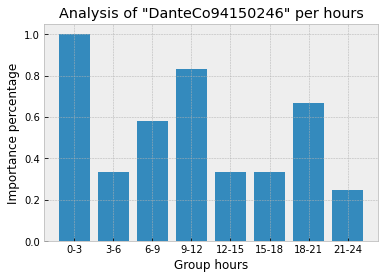

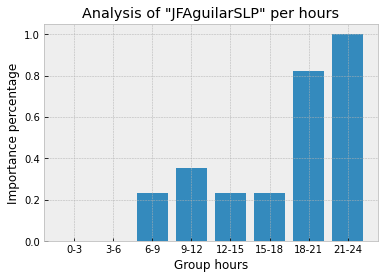

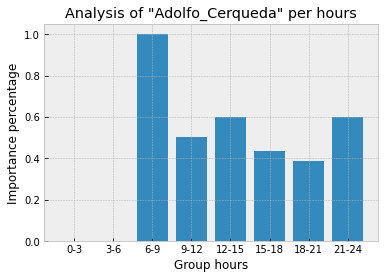

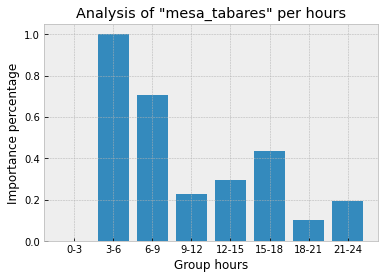

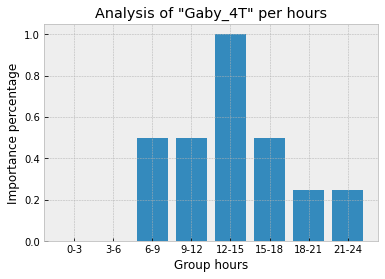

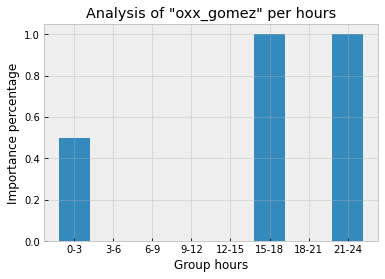

In [ ]:
for user in users[:20]:
  df_user = df[df['username'] == user]
  if len(df_user) < 20:
    continue

  group_hours = range(24//group_size)
  prev = 0
  group_names = []
  for group in group_hours:
    group_names.append(f'{prev}-{(group+1)*group_size}')
    prev = (group+1)*group_size

  nlikes_dist = df_user.groupby('group_hours')['nlikes'].median()
  nlikes_group = []
  for group in group_hours:
    if group in nlikes_dist:
      nlikes_group.append(nlikes_dist[group])
    else:
      nlikes_group.append(0)
  max_num = np.max(nlikes_group)
  nlikes_group = nlikes_group / max_num
  df_group = pd.DataFrame({"nlikes":nlikes_group}, index = group_hours)
  plt.bar(group_names, nlikes_group)
  plt.title(f'Analysis of "{user}" per hours')
  plt.ylabel('Importance percentage')
  plt.xlabel('Group hours')
  plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


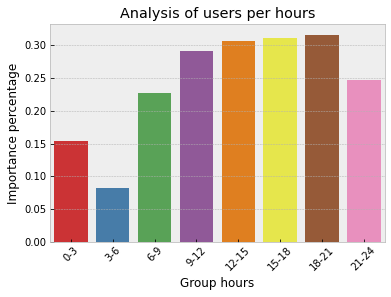

In [ ]:

group_size = 3
df['group_hours'] = df['hour'].map(lambda w: w//group_size)

group_lists = [[] for _ in range(24//group_size)]

for user in users:
  df_user = df[df['username'] == user]
  #if len(df_user) < 20:
  #  continue

  group_hours = range(24//group_size)
  prev = 0
  group_names = []
  for group in group_hours:
    group_names.append(f'{prev}-{(group+1)*group_size}')
    prev = (group+1)*group_size

  nlikes_dist = df_user.groupby('group_hours')['nlikes'].median()
  nlikes_group = []
  for group in group_hours:
    if group in nlikes_dist:
      nlikes_group.append(nlikes_dist[group])
    else:
      nlikes_group.append(0)
  max_num = np.max(nlikes_group)
  if max_num > 0:
    nlikes_group = nlikes_group / max_num

  for i in group_hours:
    group_lists[i].append(nlikes_group[i])


poderoso_group = [np.mean(group_lists[i]) for i in group_hours]
df_group = pd.DataFrame({"nlikes":poderoso_group}, index = group_hours)
sns.barplot(group_names, poderoso_group, palette='Set1')
plt.title(f'Analysis of users per hours')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel('Importance percentage')
plt.xlabel('Group hours')
plt.show()

The graph in which all the tweets are gathered we can see that there is a clear increase between 9 am and 9 pm, this may be due to the fact that the use of social networks increases during the day and that there are leisure times, we can note that the largest are from 3:00 p.m. to 9:00 p.m. with a total importance of 60%. It sounds reasonable that these hours in which there is more traffic of tweets since they are the hours that are usually no longer work or school. While on the other side of 9:00 p.m. to 6:00 a.m. are the hours with less traffic, this is to be expected since they are the hours in which people sleep, so it seems obvious that there is a considerable decrease in the use of the Twitter social network.

Para hambre, filtremos por sentimiento 'negativo' -> enojo


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


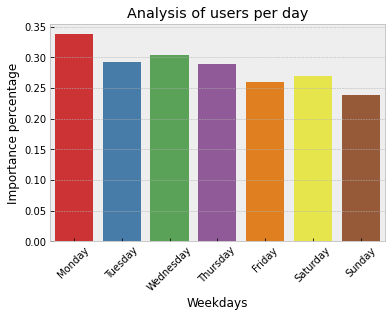

In [ ]:

group_size = 3
df['group_hours'] = df['hour'].map(lambda w: w//group_size)

group_lists = [[] for _ in range(24//group_size)]

for user in users:
  df_user = df[df['username'] == user]
  #if len(df_user) < 20:
  #  continue

  #group_hours = range(24//group_size)
  ##prev = 0
  #group_names = []
  #for group in group_hours:
  #  group_names.append(f'{prev}-{(group+1)*group_size}')
  #  prev = (group+1)*group_size

  nlikes_dist = df_user.groupby('weekday')['nlikes'].median()
  nlikes_group = []
  for group in week:
    if group in nlikes_dist:
      nlikes_group.append(nlikes_dist[group])
    else:
      nlikes_group.append(0)
  max_num = np.max(nlikes_group)
  if max_num > 0:
    nlikes_group = nlikes_group / max_num

  for i, _ in enumerate(week):
    group_lists[i].append(nlikes_group[i])


poderoso_group = [np.mean(group_lists[i]) for i, _ in enumerate(week)]
df_group = pd.DataFrame({"nlikes":poderoso_group}, index = week)
sns.barplot(week, poderoso_group, palette='Set1')
plt.title(f'Analysis of users per day')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel('Importance percentage')
plt.xlabel('Weekdays')
plt.show()

In this graph we can see the average number of likes but by day of the week. Which shows a downward trend throughout the week. Being the Monday with the highest number of interactions on the social network, this may be due to the fact that it is the first day of the week, so users return to using the app after a weekend. While the range of the days Tuesday-Thursday, it remains at the same level of importance, that is, a number of somewhat more common use. while the weekend shows a clear decrease, we attribute this to the fact that people leave the social network a little to have a weekend off from social networks, as well as the performance of different activities that cannot be performed during the week.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


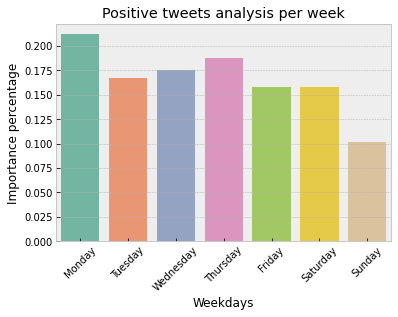

In [ ]:

group_size = 3
df['group_hours'] = df['hour'].map(lambda w: w//group_size)

group_lists = [[] for _ in range(24//group_size)]

for user in users:
  df_user = df[df['username'] == user]
  df_user = df_user[df_user['sentiment'] == 1]

  #if len(df_user) < 20:
  #  continue

  #group_hours = range(24//group_size)
  ##prev = 0
  #group_names = []
  #for group in group_hours:
  #  group_names.append(f'{prev}-{(group+1)*group_size}')
  #  prev = (group+1)*group_size

  nlikes_dist = df_user.groupby('weekday')['nlikes'].median()
  nlikes_group = []
  for group in week:
    if group in nlikes_dist:
      nlikes_group.append(nlikes_dist[group])
    else:
      nlikes_group.append(0)
  max_num = np.max(nlikes_group)
  if max_num > 0:
    nlikes_group = nlikes_group / max_num

  for i, _ in enumerate(week):
    group_lists[i].append(nlikes_group[i])


poderoso_group = [np.mean(group_lists[i]) for i, _ in enumerate(week)]
df_group = pd.DataFrame({"nlikes":poderoso_group}, index = week)
sns.barplot(week, poderoso_group, palette='Set2')
plt.title(f'Positive tweets analysis per week')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel('Importance percentage')
plt.xlabel('Weekdays')
plt.show()

The following graph shows the number of likes per day of the week but with the positive sentiment filter. We can see that the most important with a value above 20% is on Monday. We assume that this is because it is the first day of the week so people have rested on their weekend and the week begins in a good mood. The positive mood decreases as the week progresses.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


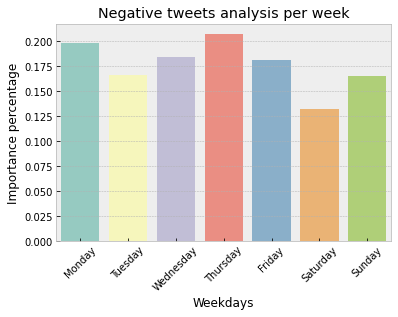

In [ ]:

group_size = 3
df['group_hours'] = df['hour'].map(lambda w: w//group_size)

group_lists = [[] for _ in range(24//group_size)]

for user in users:
  df_user = df[df['username'] == user]
  df_user = df_user[df_user['sentiment'] == -1]

  #if len(df_user) < 20:
  #  continue

  #group_hours = range(24//group_size)
  ##prev = 0
  #group_names = []
  #for group in group_hours:
  #  group_names.append(f'{prev}-{(group+1)*group_size}')
  #  prev = (group+1)*group_size

  nlikes_dist = df_user.groupby('weekday')['nlikes'].median()
  nlikes_group = []
  for group in week:
    if group in nlikes_dist:
      nlikes_group.append(nlikes_dist[group])
    else:
      nlikes_group.append(0)
  max_num = np.max(nlikes_group)
  if max_num > 0:
    nlikes_group = nlikes_group / max_num

  for i, _ in enumerate(week):
    group_lists[i].append(nlikes_group[i])


poderoso_group = [np.mean(group_lists[i]) for i, _ in enumerate(week)]
df_group = pd.DataFrame({"nlikes":poderoso_group}, index = week)
sns.barplot(week, poderoso_group, palette='Set3')
plt.title(f'Negative tweets analysis per week')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel('Importance percentage')
plt.xlabel('Weekdays')
plt.show()

This graph represents the data filtered by negative sentiment, with Thursday as the highest incidence day, which may be caused by an increase in stress throughout the week. Now let's compare a little the positive sentiment graph with the negative one, on Monday the positive sentiment is more predominant, the difference is not so great in terms of values since the positive sentiment exceeds 0.20, but if we observe carefully something really important happens, the Values throughout the week are generally mostly negative, with Monday and Saturday being the only days in which there is a greater number of percentage importance between both sentiments. Above all, there is a big difference on Sundays, since on the positive sentiment side it barely exceeds 0.10, while on the negative side it almost has a value of 0.175, having an increase of almost 50%.

In [ ]:
df.columns, df['emotion'].unique(), df['sentiment'].unique()

(Index(['username', 'created_at', 'verified', 'followers_count', 'date',
        'timezone', 'tweet', 'nlikes', 'nreplies', 'nretweets', 'lang',
        'sentiment', 'emotion', 'hate_speech', 'year', 'month', 'day', 'hour',
        'minute', 'second', 'minute_day', 'Emotion_anger', 'Emotion_disgust',
        'Emotion_fear', 'Emotion_joy', 'Emotion_others', 'Emotion_sadness',
        'Emotion_surprise', 'weekday', 'group_hours'],
       dtype='object'),
 array(['others', 'joy', 'sadness', 'anger', 'surprise', 'fear', 'disgust'],
       dtype=object),
 array([ 0, -1,  1]))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


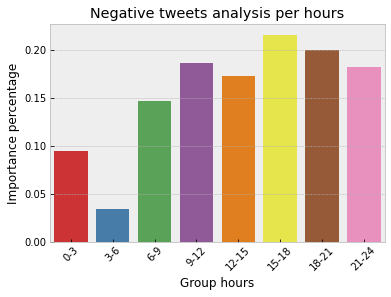

In [ ]:

group_size = 3
df['group_hours'] = df['hour'].map(lambda w: w//group_size)

group_lists = [[] for _ in range(24//group_size)]

for user in users:
  df_user = df[df['username'] == user]
  df_user = df_user[df_user['sentiment'] == -1]

  #if len(df_user) < 20:
  #  continue

  group_hours = range(24//group_size)
  prev = 0
  group_names = []
  for group in group_hours:
    group_names.append(f'{prev}-{(group+1)*group_size}')
    prev = (group+1)*group_size

  nlikes_dist = df_user.groupby('group_hours')['nlikes'].median()
  nlikes_group = []
  for group in group_hours:
    if group in nlikes_dist:
      nlikes_group.append(nlikes_dist[group])
    else:
      nlikes_group.append(0)
  max_num = np.max(nlikes_group)
  if max_num > 0:
    nlikes_group = nlikes_group / max_num

  for i in group_hours:
    group_lists[i].append(nlikes_group[i])


poderoso_group = [np.mean(group_lists[i]) for i in group_hours]
df_group = pd.DataFrame({"nlikes":poderoso_group}, index = group_hours)
#plt.bar(group_names, poderoso_group)
sns.barplot(group_names, poderoso_group, palette='Set1')

plt.title(f'Negative tweets analysis per hours')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel('Importance percentage')
plt.xlabel('Group hours')
plt.show()

The following graph shows us the distribution by percentage importance of the negative sentiment through the different hours of the day. We can clearly see that the hours with less recurrence are from 0:00 to 6:00, this is because they are hours of rest. While you start to see an increase after 6:00, making it the most active hour group in this sentiment is found in the afternoon in the hours of 15:00 to 18:00, this may be thanks to a load of stress throughout the day so these kinds of feelings are more common, after 6:00 p.m. you start to see a constant decrease in each following group of hours, either due to disuse of the app and because bedtime begins .

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


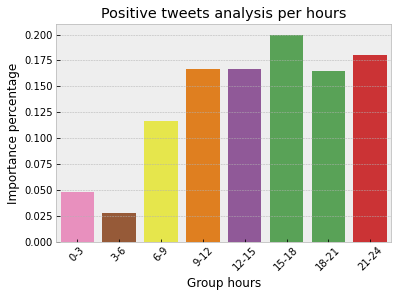

In [ ]:

group_size = 3
df['group_hours'] = df['hour'].map(lambda w: w//group_size)

group_lists = [[] for _ in range(24//group_size)]

for user in users:
  df_user = df[df['username'] == user]
  df_user = df_user[df_user['sentiment'] == 1]

  #if len(df_user) < 20:
  #  continue

  group_hours = range(24//group_size)
  prev = 0
  group_names = []
  for group in group_hours:
    group_names.append(f'{prev}-{(group+1)*group_size}')
    prev = (group+1)*group_size

  nlikes_dist = df_user.groupby('group_hours')['nlikes'].median()
  nlikes_group = []
  for group in group_hours:
    if group in nlikes_dist:
      nlikes_group.append(nlikes_dist[group])
    else:
      nlikes_group.append(0)
  max_num = np.max(nlikes_group)
  if max_num > 0:
    nlikes_group = nlikes_group / max_num

  for i in group_hours:
    group_lists[i].append(nlikes_group[i])



poderoso_group = [np.mean(group_lists[i]) for i in group_hours]
df_group = pd.DataFrame({"nlikes":poderoso_group}, index = group_hours)
#plt.bar(group_names, poderoso_group)
sns.barplot(group_names, poderoso_group, palette='Set1_r')

plt.title(f'Positive tweets analysis per hours')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel('Importance percentage')
plt.xlabel('Group hours')
plt.show()

In the hourly graph filtered by positive sentiment we can see that in the same way the hours from 3:00 p.m. to 6:00 p.m. are the ones with the highest incidence, so we can say that it is the time when there is more traffic and interaction in the app. from Twitter. We can also observe that the hours of sleep, that is, 00:00 to 6:00, are the ones with the lowest percentage weighting. We can compare with the graph of negative sentiments and we can observe that the positive ones have a lower percentage importance, so the predominant sentiment is the negative one.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


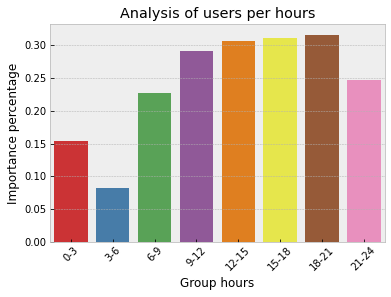

In [ ]:

group_size = 3
df['group_hours'] = df['hour'].map(lambda w: w//group_size)

group_lists = [[] for _ in range(24//group_size)]

for user in users:
  df_user = df[df['username'] == user]
  #if len(df_user) < 20:
  #  continue

  group_hours = range(24//group_size)
  prev = 0
  group_names = []
  for group in group_hours:
    group_names.append(f'{prev}-{(group+1)*group_size}')
    prev = (group+1)*group_size

  nlikes_dist = df_user.groupby('group_hours')['nlikes'].median()
  nlikes_group = []
  for group in group_hours:
    if group in nlikes_dist:
      nlikes_group.append(nlikes_dist[group])
    else:
      nlikes_group.append(0)
  max_num = np.max(nlikes_group)
  if max_num > 0:
    nlikes_group = nlikes_group / max_num

  for i in group_hours:
    group_lists[i].append(nlikes_group[i])


poderoso_group = [np.mean(group_lists[i]) for i in group_hours]
df_group = pd.DataFrame({"nlikes":poderoso_group}, index = group_hours)
sns.barplot(group_names, poderoso_group, palette='Set1')
plt.title(f'Analysis of users per hours')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel('Importance percentage')
plt.xlabel('Group hours')
plt.show()

In [ ]:
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.graphics.gofplots import qqplot
import warnings
from IPython.display import display, Math, Latex, Markdown

warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.DataFrame({gh: group_lists[gh] for gh in group_hours})
df.columns = group_hours
df

,0,1,2,3,4,5,6,7
0,0.363636,0.000000,0.000000,0.000000,0.181818,0.545455,0.363636,1.000000
1,0.000000,0.000000,0.613636,0.818182,0.704545,0.363636,1.000000,0.818182
2,0.000000,0.000000,0.400000,0.600000,0.000000,0.000000,1.000000,0.000000
3,0.000000,0.000000,0.000000,0.037515,0.000000,0.410892,1.000000,0.000000
4,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.615385,0.923077
...,...,...,...,...,...,...,...,...
225,0.000000,0.000000,1.000000,0.083333,0.000000,0.333333,0.833333,0.000000
226,1.000000,0.666667,1.000000,0.666667,0.666667,0.666667,0.000000,0.000000
227,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
228,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000


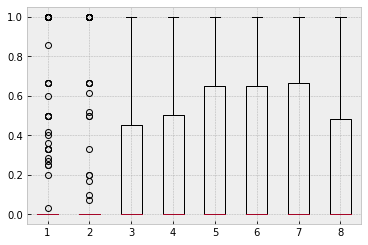

In [ ]:
plt.boxplot(group_lists)
plt.show()

In [ ]:
from scipy import stats as st
for a in group_hours:
  for b in group_hours:
    if a == b:
      continue
    _, p_value = st.ttest_ind(group_lists[a], group_lists[b], alternative='two-sided')
    print(f'{a} != {b} : p-value ({p_value})') 


0 != 1 : p-value (0.008885680037144253)
0 != 2 : p-value (0.024756281840590613)
0 != 3 : p-value (5.36354491866239e-05)
0 != 4 : p-value (9.062051528548929e-06)
0 != 5 : p-value (5.074600605050756e-06)
0 != 6 : p-value (3.833561791443069e-06)
0 != 7 : p-value (0.0061261431417184795)
1 != 0 : p-value (0.008885680037144253)
1 != 2 : p-value (1.258882574305051e-06)
1 != 3 : p-value (2.4403136160597803e-11)
1 != 4 : p-value (1.8923917898668517e-12)
1 != 5 : p-value (7.477879867076283e-13)
1 != 6 : p-value (8.099516082716742e-13)
1 != 7 : p-value (1.2002414044007427e-07)
2 != 0 : p-value (0.024756281840590613)
2 != 1 : p-value (1.258882574305051e-06)
2 != 3 : p-value (0.07727273790131332)
2 != 4 : p-value (0.028706107479218496)
2 != 5 : p-value (0.021027411806973813)
2 != 6 : p-value (0.01588642499096271)
2 != 7 : p-value (0.5993407163675699)
3 != 0 : p-value (5.36354491866239e-05)
3 != 1 : p-value (2.4403136160597803e-11)
3 != 2 : p-value (0.07727273790131332)
3 != 4 : p-value (0.660436386

In [ ]:
from scipy import stats as st
for a in group_hours:
  for b in group_hours:
    if a == b:
      continue
    _, p_value = st.ttest_ind(group_lists[a], group_lists[b])#, alternative='two-sided')
    print(f'{a} != {b} : p-value ({p_value})') 


0 != 1 : p-value (0.008885680037144253)
0 != 2 : p-value (0.024756281840590613)
0 != 3 : p-value (5.36354491866239e-05)
0 != 4 : p-value (9.062051528548929e-06)
0 != 5 : p-value (5.074600605050756e-06)
0 != 6 : p-value (3.833561791443069e-06)
0 != 7 : p-value (0.0061261431417184795)
1 != 0 : p-value (0.008885680037144253)
1 != 2 : p-value (1.258882574305051e-06)
1 != 3 : p-value (2.4403136160597803e-11)
1 != 4 : p-value (1.8923917898668517e-12)
1 != 5 : p-value (7.477879867076283e-13)
1 != 6 : p-value (8.099516082716742e-13)
1 != 7 : p-value (1.2002414044007427e-07)
2 != 0 : p-value (0.024756281840590613)
2 != 1 : p-value (1.258882574305051e-06)
2 != 3 : p-value (0.07727273790131332)
2 != 4 : p-value (0.028706107479218496)
2 != 5 : p-value (0.021027411806973813)
2 != 6 : p-value (0.01588642499096271)
2 != 7 : p-value (0.5993407163675699)
3 != 0 : p-value (5.36354491866239e-05)
3 != 1 : p-value (2.4403136160597803e-11)
3 != 2 : p-value (0.07727273790131332)
3 != 4 : p-value (0.660436386

In [ ]:
from scipy import stats as st
for a in group_hours:
  for b in group_hours:
    if a == b:
      continue
    _, p_value = st.ttest_ind(group_lists[a], group_lists[b], alternative='less')
    print(f'{a} != {b} : p-value ({p_value})') 


0 != 1 : p-value (0.9955571599814279)
0 != 2 : p-value (0.012378140920295306)
0 != 3 : p-value (2.681772459331195e-05)
0 != 4 : p-value (4.531025764274464e-06)
0 != 5 : p-value (2.537300302525378e-06)
0 != 6 : p-value (1.9167808957215347e-06)
0 != 7 : p-value (0.0030630715708592398)
1 != 0 : p-value (0.0044428400185721265)
1 != 2 : p-value (6.294412871525254e-07)
1 != 3 : p-value (1.2201568080298901e-11)
1 != 4 : p-value (9.461958949334259e-13)
1 != 5 : p-value (3.7389399335381413e-13)
1 != 6 : p-value (4.049758041358371e-13)
1 != 7 : p-value (6.001207022003713e-08)
2 != 0 : p-value (0.9876218590797047)
2 != 1 : p-value (0.9999993705587129)
2 != 3 : p-value (0.03863636895065666)
2 != 4 : p-value (0.014353053739609248)
2 != 5 : p-value (0.010513705903486907)
2 != 6 : p-value (0.007943212495481355)
2 != 7 : p-value (0.29967035818378496)
3 != 0 : p-value (0.9999731822754067)
3 != 1 : p-value (0.9999999999877984)
3 != 2 : p-value (0.9613636310493433)
3 != 4 : p-value (0.3302181934411449)
3

In [ ]:
!pip install --upgrade scipy
import scipy
scipy.__version__


'1.7.3'